In [1]:
# Generic inputs for most ML tasks
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.preprocessing import OneHotEncoder

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
# from sklearn.ensemble import HistGradientBoostingRegressor
import xgboost as xgb

pd.options.display.float_format = '{:,.2f}'.format

# setup interactive notebook mode
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from IPython.display import display, HTML

# Initialize lists to collect model performance
model_names = []
model_maes = []
model_mabs = []

RuntimeError: module was compiled against NumPy C-API version 0x10 (NumPy 1.23) but the running NumPy has C-API version 0xf. Check the section C-API incompatibility at the Troubleshooting ImportError section at https://numpy.org/devdocs/user/troubleshooting-importerror.html#c-api-incompatibility for indications on how to solve this problem.

# Read, pre-process and visualize data

In [2]:
data_set = pd.read_csv('MultipleSources-2019-2025.csv')
data_set.head()

,Date,SP500,Futures,Nikkei,FTSE,DAX
0,2025-04-02,"5,670.97","5,512.00","35,725.87","8,608.48","22,390.84"
1,2025-04-01,"5,633.07","5,674.50","35,624.48","8,634.80","22,539.98"
2,2025-03-31,"5,611.85","5,653.25","35,617.56","8,582.81","22,163.49"
3,2025-03-28,"5,580.94","5,623.00","37,120.33","8,658.85","22,461.52"
4,2025-03-27,"5,693.31","5,739.25","37,799.97","8,666.12","22,678.74"


In [3]:
len(data_set)
data_set.isna().sum()
data_set.dtypes

1509

Date        0
SP500       0
Futures     0
Nikkei     98
FTSE       30
DAX        24
dtype: int64

Date        object
SP500      float64
Futures    float64
Nikkei     float64
FTSE       float64
DAX        float64
dtype: object

In [4]:
data_set.columns

# Step 1: Convert to datetime
data_set['Date'] = pd.to_datetime(data_set['Date'])

# ✅ Step 2: Extract day of week
data_set['day_of_week'] = data_set['Date'].dt.dayofweek  # 0=Mon, ..., 6=Sun

# Step 3 (optional): If you still want UNIX timestamp
data_set['Date'] = data_set['Date'].astype(np.int64) // 10**9

data_set.tail()

Index(['Date', 'SP500', 'Futures', 'Nikkei', 'FTSE', 'DAX'], dtype='object')

,Date,SP500,Futures,Nikkei,FTSE,DAX,day_of_week
1504,1554768000,"2,878.20","2,882.50","21,802.59","7,425.57","11,850.57",1
1505,1554681600,"2,895.77","2,898.25","21,761.65","7,451.89","11,963.40",0
1506,1554422400,"2,892.74","2,896.00","21,807.50","7,446.87","12,009.75",4
1507,1554336000,"2,879.39","2,882.75","21,724.95","7,401.94","11,988.01",3
1508,1554249600,"2,873.40","2,879.75","21,713.21","7,418.28","11,954.40",2


In [5]:
# Reshape to 2D as required by OneHotEncoder
encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
day_of_week_encoded = encoder.fit_transform(data_set[['day_of_week']])

In [6]:
# Get feature names like ['day_of_week_0', 'day_of_week_1', ...]
encoded_cols = encoder.get_feature_names_out(['day_of_week'])
encoded_df = pd.DataFrame(day_of_week_encoded, columns=encoded_cols, index=data_set.index)
data_set = pd.concat([data_set.drop(columns=['day_of_week']), encoded_df], axis=1)

In [7]:
def add_lag_features(df, columns, lags):
    """
    Adds lag features for given columns and lag days.

    Parameters:
    df (pd.DataFrame): Original dataset
    columns (list): Columns for which to create lag features
    lags (list): List of lag values (e.g., [1, 2, 3])

    Returns:
    pd.DataFrame: Dataset with new lag features
    """
    for col in columns:
        for lag in lags:
            df[f'{col}_lag_{lag}'] = df[col].shift(lag)
    return df


lag_columns = ['SP500', 'DAX', 'FTSE', 'Nikkei']
lag_days = [1, 2, 3] 

data_set = add_lag_features(data_set, lag_columns, lag_days)
data_set = data_set.dropna()  # Drop rows with NaNs from lags
data_set.head()


data_set = data_set.sort_values(by='Date').reset_index(drop=True)



,Date,SP500,Futures,Nikkei,FTSE,DAX,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,...,SP500_lag_3,DAX_lag_1,DAX_lag_2,DAX_lag_3,FTSE_lag_1,FTSE_lag_2,FTSE_lag_3,Nikkei_lag_1,Nikkei_lag_2,Nikkei_lag_3
3,1743120000,"5,580.94","5,623.00","37,120.33","8,658.85","22,461.52",0.00,0.00,0.00,0.00,...,"5,670.97","22,163.49","22,539.98","22,390.84","8,582.81","8,634.80","8,608.48","35,617.56","35,624.48","35,725.87"
4,1743033600,"5,693.31","5,739.25","37,799.97","8,666.12","22,678.74",0.00,0.00,0.00,1.00,...,"5,633.07","22,461.52","22,163.49","22,539.98","8,658.85","8,582.81","8,634.80","37,120.33","35,617.56","35,624.48"
5,1742947200,"5,712.20","5,759.50","38,027.29","8,689.59","22,839.03",0.00,0.00,1.00,0.00,...,"5,611.85","22,678.74","22,461.52","22,163.49","8,666.12","8,658.85","8,582.81","37,799.97","37,120.33","35,617.56"
6,1742860800,"5,776.65","5,826.50","37,780.54","8,663.80","23,109.79",0.00,1.00,0.00,0.00,...,"5,580.94","22,839.03","22,678.74","22,461.52","8,689.59","8,666.12","8,658.85","38,027.29","37,799.97","37,120.33"
7,1742774400,"5,767.57","5,815.50","37,608.49","8,638.01","22,852.66",1.00,0.00,0.00,0.00,...,"5,693.31","23,109.79","22,839.03","22,678.74","8,663.80","8,689.59","8,666.12","37,780.54","38,027.29","37,799.97"


In [8]:
data_set['SP500_next'] = data_set['SP500'].shift(-1)
data_set = data_set.dropna()


In [9]:
X_train, X_test, y_train, y_test = train_test_split(data_set.drop(columns = ['SP500_next']), data_set['SP500_next'], test_size=0.2,shuffle = False)
## Removing the Date feature resulted in higher Mean Absolute Error (MAE) across all models
X_train
X_test
y_train
y_test

,Date,SP500,Futures,Nikkei,FTSE,DAX,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,...,SP500_lag_3,DAX_lag_1,DAX_lag_2,DAX_lag_3,FTSE_lag_1,FTSE_lag_2,FTSE_lag_3,Nikkei_lag_1,Nikkei_lag_2,Nikkei_lag_3
0,1554249600,"2,873.40","2,879.75","21,713.21","7,418.28","11,954.40",0.00,0.00,1.00,0.00,...,"2,895.77","11,988.01","12,009.75","11,963.40","7,401.94","7,446.87","7,451.89","21,724.95","21,807.50","21,761.65"
1,1554336000,"2,879.39","2,882.75","21,724.95","7,401.94","11,988.01",0.00,0.00,0.00,1.00,...,"2,878.20","12,009.75","11,963.40","11,850.57","7,446.87","7,451.89","7,425.57","21,807.50","21,761.65","21,802.59"
2,1554422400,"2,892.74","2,896.00","21,807.50","7,446.87","12,009.75",0.00,0.00,0.00,0.00,...,"2,888.21","11,963.40","11,850.57","11,905.91","7,451.89","7,425.57","7,421.91","21,761.65","21,802.59","21,687.57"
3,1554681600,"2,895.77","2,898.25","21,761.65","7,451.89","11,963.40",1.00,0.00,0.00,0.00,...,"2,888.32","11,850.57","11,905.91","11,935.20","7,425.57","7,421.91","7,417.95","21,802.59","21,687.57","21,711.38"
4,1554768000,"2,878.20","2,882.50","21,802.59","7,425.57","11,850.57",0.00,1.00,0.00,0.00,...,"2,907.41","11,905.91","11,935.20","11,999.93","7,421.91","7,417.95","7,437.06","21,687.57","21,711.38","21,870.56"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
867,1704931200,"4,780.24","4,815.50","35,049.86","7,576.59","16,547.03",0.00,0.00,0.00,1.00,...,"4,739.21","16,704.56","16,571.68","16,431.69","7,624.93","7,558.34","7,446.29","35,577.11","35,619.18","35,477.75"
868,1705017600,"4,783.83","4,816.50","35,577.11","7,624.93","16,704.56",0.00,0.00,0.00,0.00,...,"4,780.94","16,571.68","16,431.69","16,567.35","7,558.34","7,446.29","7,459.09","35,619.18","35,477.75","35,466.17"
869,1705363200,"4,765.98","4,798.50","35,619.18","7,558.34","16,571.68",0.00,1.00,0.00,0.00,...,"4,839.81","16,431.69","16,567.35","16,555.13","7,446.29","7,459.09","7,461.93","35,477.75","35,466.17","35,963.27"
870,1705449600,"4,739.21","4,771.25","35,477.75","7,446.29","16,431.69",0.00,0.00,1.00,0.00,...,"4,850.43","16,567.35","16,555.13","16,683.36","7,459.09","7,461.93","7,487.71","35,466.17","35,963.27","36,546.95"


,Date,SP500,Futures,Nikkei,FTSE,DAX,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,...,SP500_lag_3,DAX_lag_1,DAX_lag_2,DAX_lag_3,FTSE_lag_1,FTSE_lag_2,FTSE_lag_3,Nikkei_lag_1,Nikkei_lag_2,Nikkei_lag_3
872,1705622400,"4,839.81","4,869.50","35,963.27","7,461.93","16,555.13",0.00,0.00,0.00,0.00,...,"4,868.55","16,683.36","16,627.09","16,889.92","7,487.71","7,485.73","7,527.67","36,546.95","36,517.57","36,226.48"
873,1705881600,"4,850.43","4,881.00","36,546.95","7,487.71","16,683.36",1.00,0.00,0.00,0.00,...,"4,894.16","16,627.09","16,889.92","16,906.92","7,485.73","7,527.67","7,529.73","36,517.57","36,226.48","36,236.47"
874,1705968000,"4,864.60","4,895.00","36,517.57","7,485.73","16,627.09",0.00,1.00,0.00,0.00,...,"4,890.97","16,889.92","16,906.92","16,961.39","7,527.67","7,529.73","7,635.09","36,226.48","36,236.47","35,751.07"
875,1706054400,"4,868.55","4,898.00","36,226.48","7,527.67","16,889.92",0.00,0.00,1.00,0.00,...,"4,927.93","16,906.92","16,961.39","16,941.71","7,529.73","7,635.09","7,632.74","36,236.47","35,751.07","36,026.94"
876,1706140800,"4,894.16","4,923.25","36,236.47","7,529.73","16,906.92",0.00,0.00,0.00,1.00,...,"4,924.97","16,961.39","16,941.71","16,972.34","7,635.09","7,632.74","7,666.31","35,751.07","36,026.94","36,065.86"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1086,1742515200,"5,667.56","5,718.25","37,677.06","8,646.79","22,891.68",0.00,0.00,0.00,0.00,...,"5,712.20","22,852.66","23,109.79","22,839.03","8,638.01","8,663.80","8,689.59","37,608.49","37,780.54","38,027.29"
1087,1742774400,"5,767.57","5,815.50","37,608.49","8,638.01","22,852.66",1.00,0.00,0.00,0.00,...,"5,693.31","23,109.79","22,839.03","22,678.74","8,663.80","8,689.59","8,666.12","37,780.54","38,027.29","37,799.97"
1088,1742860800,"5,776.65","5,826.50","37,780.54","8,663.80","23,109.79",0.00,1.00,0.00,0.00,...,"5,580.94","22,839.03","22,678.74","22,461.52","8,689.59","8,666.12","8,658.85","38,027.29","37,799.97","37,120.33"
1089,1742947200,"5,712.20","5,759.50","38,027.29","8,689.59","22,839.03",0.00,0.00,1.00,0.00,...,"5,611.85","22,678.74","22,461.52","22,163.49","8,666.12","8,658.85","8,582.81","37,799.97","37,120.33","35,617.56"


0     2,879.39
1     2,892.74
2     2,895.77
3     2,878.20
4     2,888.21
        ...   
867   4,783.83
868   4,765.98
869   4,739.21
870   4,780.94
871   4,839.81
Name: SP500_next, Length: 872, dtype: float64

872    4,850.43
873    4,864.60
874    4,868.55
875    4,894.16
876    4,890.97
         ...   
1086   5,767.57
1087   5,776.65
1088   5,712.20
1089   5,693.31
1090   5,580.94
Name: SP500_next, Length: 219, dtype: float64

# Decison tree


In [10]:
clf = DecisionTreeRegressor(random_state=50)

clf = clf.fit(X_train, y_train) 

In [11]:
X_train.columns
clf.feature_importances_

Index(['Date', 'SP500', 'Futures', 'Nikkei', 'FTSE', 'DAX', 'day_of_week_0',
       'day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4',
       'SP500_lag_1', 'SP500_lag_2', 'SP500_lag_3', 'DAX_lag_1', 'DAX_lag_2',
       'DAX_lag_3', 'FTSE_lag_1', 'FTSE_lag_2', 'FTSE_lag_3', 'Nikkei_lag_1',
       'Nikkei_lag_2', 'Nikkei_lag_3'],
      dtype='object')

array([4.21200269e-05, 2.29278722e-04, 2.09473028e-05, 1.08100110e-04,
       2.26535605e-06, 9.94367862e-05, 6.57707881e-06, 1.18682733e-05,
       2.65348732e-07, 4.74845267e-07, 6.73971878e-07, 9.98130595e-01,
       6.10961111e-05, 4.98823295e-04, 1.86150020e-04, 1.30423958e-06,
       4.56780147e-04, 1.21566425e-05, 4.01624401e-05, 7.05631563e-05,
       9.26836993e-06, 2.42990137e-06, 8.66297209e-06])

In [12]:
test_output = pd.DataFrame(clf.predict(X_test), index = X_test.index, columns = ['pred_SP500_next'])
test_output = test_output.merge(y_test, left_index = True, right_index = True)
test_output.head()
mean_absolute_error = abs(test_output['pred_SP500_next'] - test_output['SP500_next']).mean()
print('Mean absolute error is ')
print(mean_absolute_error)
mean_absolute_percentage_error = abs(test_output['pred_SP500_next'] - test_output['SP500_next']).mean() / test_output['SP500_next'].mean()
print('Mean absolute percentage error is ')
print(mean_absolute_percentage_error)

model_names.append("Decision Tree")
model_maes.append(mean_absolute_error)
model_mabs.append(mean_absolute_percentage_error)

,pred_SP500_next,SP500_next
872,"4,839.81","4,850.43"
873,"4,839.81","4,864.60"
874,"4,719.55","4,868.55"
875,"4,719.55","4,894.16"
876,"4,719.55","4,890.97"


Mean absolute error is 
827.6713698630134
Mean absolute percentage error is 
0.14917514208917582


## Bagging Regressor ## 

In [13]:
regr = BaggingRegressor(random_state=50, n_estimators = 200, max_samples = 800)

regr = regr.fit(X_train, y_train) 

In [14]:
test_output = pd.DataFrame(regr.predict(X_test), index = X_test.index, columns = ['pred_SP500_next'])
test_output = test_output.merge(y_test, left_index = True, right_index = True)
test_output.head()
mean_absolute_error = abs(test_output['pred_SP500_next'] - test_output['SP500_next']).mean()
print('Mean absolute error is ')
print(mean_absolute_error)
mean_absolute_percentage_error = abs(test_output['pred_SP500_next'] - test_output['SP500_next']).mean() / test_output['SP500_next'].mean()
print('Mean absolute percentage error is ')
print(mean_absolute_percentage_error)

model_names.append("Bagging Regressor")
model_maes.append(mean_absolute_error)
model_mabs.append(mean_absolute_percentage_error)

,pred_SP500_next,SP500_next
872,"4,807.24","4,850.43"
873,"4,793.95","4,864.60"
874,"4,785.78","4,868.55"
875,"4,774.01","4,894.16"
876,"4,771.38","4,890.97"


Mean absolute error is 
767.2207162100461
Mean absolute percentage error is 
0.13827983366554694


## Random Forest Regressor 

In [15]:
rf = RandomForestRegressor(random_state=50, min_samples_leaf = 3, max_features = "sqrt")

rf = rf.fit(X_train, y_train) 


In [16]:
X_train.columns
rf.feature_importances_

Index(['Date', 'SP500', 'Futures', 'Nikkei', 'FTSE', 'DAX', 'day_of_week_0',
       'day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4',
       'SP500_lag_1', 'SP500_lag_2', 'SP500_lag_3', 'DAX_lag_1', 'DAX_lag_2',
       'DAX_lag_3', 'FTSE_lag_1', 'FTSE_lag_2', 'FTSE_lag_3', 'Nikkei_lag_1',
       'Nikkei_lag_2', 'Nikkei_lag_3'],
      dtype='object')

array([6.77780526e-02, 1.57385351e-01, 1.02273091e-01, 4.94054942e-02,
       2.11693572e-03, 8.20213289e-03, 1.47964868e-05, 2.04458037e-05,
       1.05526059e-05, 8.82476462e-06, 1.72000851e-05, 1.68138190e-01,
       1.58881078e-01, 9.97130666e-02, 2.98485928e-02, 1.30893558e-02,
       1.15587208e-02, 4.55057965e-03, 1.97593436e-03, 4.56792916e-03,
       3.66010296e-02, 3.31482598e-02, 5.06943858e-02])

In [17]:
test_output = pd.DataFrame(rf.predict(X_test), index = X_test.index, columns = ['pred_SP500_next'])
test_output = test_output.merge(y_test, left_index = True, right_index = True)
test_output.head()
mean_absolute_error = abs(test_output['pred_SP500_next'] - test_output['SP500_next']).mean()
print('Mean absolute error is ')
print(mean_absolute_error)
mean_absolute_percentage_error = abs(test_output['pred_SP500_next'] - test_output['SP500_next']).mean() / test_output['SP500_next'].mean()
print('Mean absolute percentage error is ')
print(mean_absolute_percentage_error)

model_names.append("Random Forest Regressor")
model_maes.append(mean_absolute_error)
model_mabs.append(mean_absolute_percentage_error)

,pred_SP500_next,SP500_next
872,"4,778.21","4,850.43"
873,"4,772.26","4,864.60"
874,"4,771.44","4,868.55"
875,"4,770.19","4,894.16"
876,"4,771.44","4,890.97"


Mean absolute error is 
812.3971644650029
Mean absolute percentage error is 
0.1464221995040957


## Gradeint Boosting Regressor

In [18]:
gb = GradientBoostingRegressor(random_state=50, min_samples_leaf = 2, max_depth = 4)

gb = gb.fit(X_train, y_train) 


In [19]:
X_train.columns
gb.feature_importances_

Index(['Date', 'SP500', 'Futures', 'Nikkei', 'FTSE', 'DAX', 'day_of_week_0',
       'day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4',
       'SP500_lag_1', 'SP500_lag_2', 'SP500_lag_3', 'DAX_lag_1', 'DAX_lag_2',
       'DAX_lag_3', 'FTSE_lag_1', 'FTSE_lag_2', 'FTSE_lag_3', 'Nikkei_lag_1',
       'Nikkei_lag_2', 'Nikkei_lag_3'],
      dtype='object')

array([4.35421965e-04, 2.41657588e-04, 4.16511109e-04, 9.43814805e-05,
       5.15772786e-05, 5.04318789e-05, 0.00000000e+00, 2.71009820e-06,
       2.78874746e-07, 0.00000000e+00, 1.64329237e-06, 8.98914791e-01,
       5.52057628e-02, 4.22550618e-02, 1.62345249e-03, 5.17917187e-05,
       2.35747788e-04, 5.35342528e-05, 1.94145700e-05, 1.58321828e-05,
       2.25801187e-04, 4.57410686e-05, 5.84554598e-05])

In [20]:
test_output = pd.DataFrame(gb.predict(X_test), index = X_test.index, columns = ['pred_SP500_next'])
test_output = test_output.merge(y_test, left_index = True, right_index = True)
test_output.head()
mean_absolute_error = abs(test_output['pred_SP500_next'] - test_output['SP500_next']).mean()
print('Mean absolute error is ')
print(mean_absolute_error)
mean_absolute_percentage_error = abs(test_output['pred_SP500_next'] - test_output['SP500_next']).mean() / test_output['SP500_next'].mean()
print('Mean absolute percentage error is ')
print(mean_absolute_percentage_error)

model_names.append("Gradeint Boosting Regressor")
model_maes.append(mean_absolute_error)
model_mabs.append(mean_absolute_percentage_error)

,pred_SP500_next,SP500_next
872,"4,807.04","4,850.43"
873,"4,806.31","4,864.60"
874,"4,801.30","4,868.55"
875,"4,797.27","4,894.16"
876,"4,800.07","4,890.97"


Mean absolute error is 
752.3844868561267
Mean absolute percentage error is 
0.13560582958309955


## XGBoost Regressor 

In [21]:
# XGBoost comes with its own class for storing datasets called DMatrix. 
# It is a highly optimized class for memory and speed. 
# That's why converting datasets into this format is a requirement for the native XGBoost API:


# Create regression matrices

dtrain_reg = xgb.DMatrix(X_train, y_train, enable_categorical=True)

dtest_reg = xgb.DMatrix(X_test, y_test, enable_categorical=True)

In [22]:
params = {"objective": "reg:squarederror", "tree_method": "exact", "max_depth" : 4, "learning_rate" : 0.1} # use "tree_method" : "hist" if you need speed

In [23]:
n = 100

model = xgb.train(

   params=params,

   dtrain=dtrain_reg,

   num_boost_round=n,

)

In [24]:
from sklearn.metrics import mean_squared_error
preds = model.predict(dtest_reg)


In [25]:
test_output = pd.DataFrame(preds, index = X_test.index, columns = ['pred_SP500_next'])
test_output = test_output.merge(y_test, left_index = True, right_index = True)
test_output.head()
mean_absolute_error = abs(test_output['pred_SP500_next'] - test_output['SP500_next']).mean()
print('Mean absolute error is ')
print(mean_absolute_error)
mean_absolute_percentage_error = abs(test_output['pred_SP500_next'] - test_output['SP500_next']).mean() / test_output['SP500_next'].mean()
print('Mean absolute percentage error is ')
print(mean_absolute_percentage_error)

model_names.append("XGBoost Regressor")
model_maes.append(mean_absolute_error)
model_mabs.append(mean_absolute_percentage_error)

,pred_SP500_next,SP500_next
872,"4,813.46","4,850.43"
873,"4,813.46","4,864.60"
874,"4,811.86","4,868.55"
875,"4,796.17","4,894.16"
876,"4,796.21","4,890.97"


Mean absolute error is 
766.3043285352454
Mean absolute percentage error is 
0.13811466876245287


## Hybrid Model 

In [26]:
model = LinearRegression(fit_intercept = True)
model.fit(X_train, y_train) 

# The following gives the R-square score
model.score(X_train, y_train) 

LinearRegression()

0.9979674933143508

In [27]:
training_residuals = y_train - model.predict(X_train)

In [28]:
rf = RandomForestRegressor(random_state=50, min_samples_leaf = 3, max_features = "sqrt")

rf = rf.fit(X_train, training_residuals) 

In [29]:
pred_residuals = rf.predict(X_test)
y_pred = pred_residuals + model.predict(X_test)

In [30]:
test_output = pd.DataFrame(y_pred, index = X_test.index, columns = ['pred_SP500_next'])
test_output = test_output.merge(y_test, left_index = True, right_index = True)
test_output.head()
mean_absolute_error = abs(test_output['pred_SP500_next'] - test_output['SP500_next']).mean()
print('Mean absolute error is ')
print(mean_absolute_error)
mean_absolute_percentage_error = abs(test_output['pred_SP500_next'] - test_output['SP500_next']).mean() / test_output['SP500_next'].mean()
print('Mean absolute percentage error is ')
print(mean_absolute_percentage_error)

model_names.append("Hybrid Model")
model_maes.append(mean_absolute_error)
model_mabs.append(mean_absolute_percentage_error)

,pred_SP500_next,SP500_next
872,"4,860.51","4,850.43"
873,"4,869.55","4,864.60"
874,"4,874.70","4,868.55"
875,"4,897.94","4,894.16"
876,"4,896.88","4,890.97"


Mean absolute error is 
10.814279028126728
Mean absolute percentage error is 
0.0019491088726190937


# Hybrid (XGBoost)

In [31]:
# XGBoost on residuals
dtrain_resid = xgb.DMatrix(X_train, label=training_residuals, enable_categorical=True)
dtest_resid = xgb.DMatrix(X_test, enable_categorical=True)

In [32]:
params = {"objective": "reg:squarederror", "tree_method": "exact", "max_depth" : 4, "learning_rate" : 0.1} # use "tree_method" : "hist" if you need speed
num_round = 100

In [33]:
residual_model = xgb.train(params, dtrain_resid, num_boost_round=num_round)

# Predict residuals on test set using XGBoost
pred_residuals = residual_model.predict(dtest_resid)

# Final hybrid prediction = linear prediction + xgboost residual prediction
yy_pred = model.predict(X_test) + pred_residuals

In [34]:
test_output = pd.DataFrame(yy_pred, index = X_test.index, columns = ['pred_SP500_next'])
test_output = test_output.merge(y_test, left_index = True, right_index = True)
test_output.head()
mean_absolute_error = abs(test_output['pred_SP500_next'] - test_output['SP500_next']).mean()
print('Mean absolute error is ')
print(mean_absolute_error)
mean_absolute_percentage_error = abs(test_output['pred_SP500_next'] - test_output['SP500_next']).mean() / test_output['SP500_next'].mean()
print('Mean absolute percentage error is ')
print(mean_absolute_percentage_error)

model_names.append("Hybrid (XGBoost)")
model_maes.append(mean_absolute_error)
model_mabs.append(mean_absolute_percentage_error)

,pred_SP500_next,SP500_next
872,"4,858.10","4,850.43"
873,"4,867.87","4,864.60"
874,"4,873.50","4,868.55"
875,"4,895.61","4,894.16"
876,"4,897.16","4,890.97"


Mean absolute error is 
66.88631664219811
Mean absolute percentage error is 
0.012055238530931564


## Plotting a Graph for Comparing Results


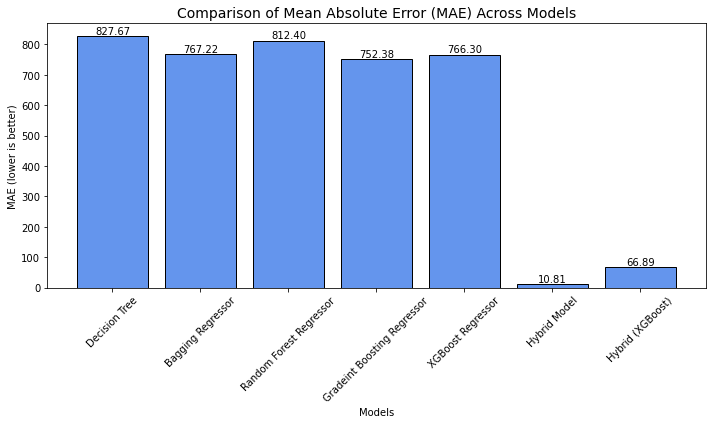

In [35]:
import matplotlib.pyplot as plt
import pandas as pd

df = pd.DataFrame({'Model': model_names, 'MAE': model_maes})

plt.figure(figsize=(10, 6))
bars = plt.bar(df['Model'], df['MAE'], color='cornflowerblue', edgecolor='black')
plt.title('Comparison of Mean Absolute Error (MAE) Across Models', fontsize=14)
plt.xlabel('Models')
plt.ylabel('MAE (lower is better)')
plt.xticks(rotation=45)

# Annotate bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.5, f'{yval:.2f}', ha='center', va='bottom')

plt.tight_layout()
plt.show();


# Plotting a Graph using MAPE

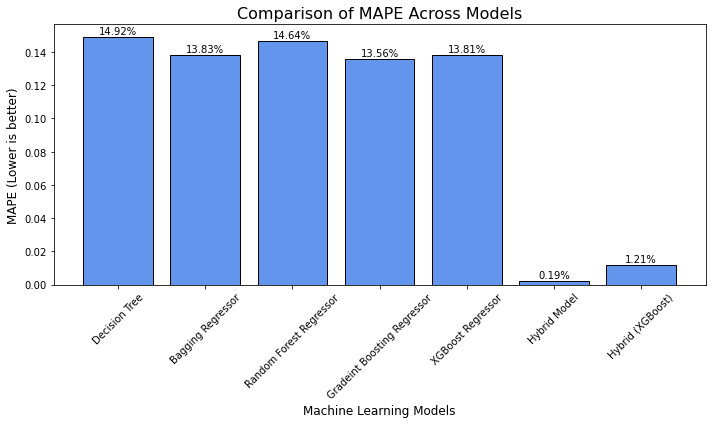

In [36]:
import matplotlib.pyplot as plt
import pandas as pd

# Create DataFrame with model names and MAPE values
df = pd.DataFrame({'Model': model_names, 'MAPE': model_mabs})

# Create the plot
plt.figure(figsize=(10, 6))
bars = plt.bar(df['Model'], df['MAPE'], color='cornflowerblue', edgecolor='black')

# Add title and axis labels
plt.title('Comparison of MAPE Across Models', fontsize=16)
plt.xlabel('Machine Learning Models', fontsize=12)
plt.ylabel('MAPE (Lower is better)', fontsize=12)
plt.xticks(rotation=45)

# Annotate each bar with its height (as percentage)
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2.0, yval + 0.0005, f"{yval:.2%}", 
             ha='center', va='bottom', fontsize=10)

# Improve layout
plt.tight_layout()
plt.show();
